<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Разделение-на-train,-test" data-toc-modified-id="Разделение-на-train,-test-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Разделение на train, test</a></span></li><li><span><a href="#Fit-MyDecisionTree" data-toc-modified-id="Fit-MyDecisionTree-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fit MyDecisionTree</a></span></li><li><span><a href="#Predict-MyDecisionTree" data-toc-modified-id="Predict-MyDecisionTree-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Predict MyDecisionTree</a></span></li><li><span><a href="#Train-with-sklearn" data-toc-modified-id="Train-with-sklearn-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train with sklearn</a></span></li><li><span><a href="#Сравнение-метрик" data-toc-modified-id="Сравнение-метрик-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Сравнение метрик</a></span></li></ul></div>

# Задание  

1. Напишите свой алгоритм построения дерева решений для задачи бинарной классификации.  
    - критерий информативности - Энтропия Шеннона
    - критерии останова - максимальная глубина, кол-во элементов в листе, прирост энтропии < x
2. Сравните результат работы своего алгоритма с sklearn    

3. (дополнительно)  Попробуйте не делать One-Hot-Encoding для категориальных переменных, а добавить их обработку в свой алгоритм. Сравните качество работы алгоритма с предыдущим решением.

## Подготовка данных
Рассмотрим задачу "Титаник" https://www.kaggle.com/c/titanic/data. Необходимо предсказать выживет пассажир или нет.

In [23]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix 

In [24]:
# считаем данные из файла в pandas DataFrame
df = pd.read_csv("train.csv")

# зафиксируем целевую переменную и удалим ее из данных
y = df['Survived']
df.drop('Survived', axis=1, inplace=True)

In [25]:
# удалим признаки PassengerId, Name, Ticket и Cabin из данных
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# заполним пропуски в признаке Age обучающей выборки медианным значением
df['Age'].fillna(df['Age'].median(), inplace=True)

#заполним пропуски в признаке Embarked обучающей выборки самыми частыми значениями этого признака
df['Embarked'].fillna(df['Embarked'].value_counts().idxmax(), inplace=True)

#заменим категориальные признаки, используя One-Hot-Encoding
categorical = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
df = pd.concat([df, pd.get_dummies(df[categorical], columns=categorical, drop_first=True)],axis=1)

df.drop(categorical, axis=1, inplace=True)

In [26]:
df.head()

,Age,Fare,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
0,22.0,7.2500,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,26.0,7.9250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,35.0,53.1000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,35.0,8.0500,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Разделение на train, test

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.1, random_state = 13)

In [28]:
print ('Train: ' + str(len(X_train)))
print ('Test: ' + str(len(X_test)))

Train: 801
Test: 90


## Fit MyDecisionTree  
Напишите свою функцию построения дерева.

Структуру дерева можно задать, например, словарем следующего вида:  
```python
{'feature_name': 'Age', # название фичи 
'threshold': 20, # порог разбиения
'left': 0,  # ссылка на левое поддерево, задан доминирующий класс
'right': 1} # ссылка на правое поддерево, задан доминирующий класс
```

In [80]:
def get_target(df):
    """
        Функция ищет доминирующий класс во входном DataFrame
        Input - DataFrame
        Output - 0 или 1
        
        Например, в исходных данных 490 нулей и 311 единиц.
        Функция должна вернуть 0.
    """

    # YOUR CODE HERE
    # Напишем поиск доминирующего класса для любого количества классов (не только 0 и 1 может быть)
    
    unique = df['target'].unique()
    
    dominance_class = unique[0]
    max_data_length = df[df['target'] == dominance_class].shape[0]
    
    for i in unique[1:]:
        data_length = df[df['target'] == i].shape[0]
        if (max_data_length < data_length):
            max_data_length = data_length
            dominance_class = i
            
    return dominance_class


def get_entropy(target):
    """
        Функция считает энтропию заданного множества.
        Input - таргет (тип - pandas.core.series.Series)
        
        Output - значение энтропии (тип - float)
    """
    # YOUR CODE HERE
    
    entropy = 0
    
    target_len = target.shape[0]
    for i in target.unique():
        p_i = target[target == i].shape[0] / target_len
        entropy -= p_i * np.log2(p_i)
    
    return entropy



def feature_separation(df, f_name):
    """
        Функция ищет лучшее разбиение для данной фичи.
        Input - df: DataFrame с 2 атрибутами (feature, target), 
                f_name: название фичи (для которой ищем разбиение)
                
        Output - прирост энтропии, порог разбиения
    """
    
    # YOUR CODE HERE
    
    
    sort_df = df.sort_values(by=[f_name])
    
    S_0 = get_entropy(sort_df['target'])
    N = sort_df.shape[0]
    
    
    f_list = list(sort_df[f_name])
    
    threshold = f_list[0]
    
    df_by_elem = sort_df['target'][sort_df[f_name] <= threshold]
    N_0 = df_by_elem.shape[0]
    N_1 = N - N_0
    
    max_delta_entropy = S_0 - N_0 / N * get_entropy(df_by_elem) - \
            N_1 / N * get_entropy(sort_df['target'][sort_df[f_name] > threshold])
    
    
    
    for elem in f_list:
        df_by_elem = sort_df['target'][sort_df[f_name] <= elem]
        N_0 = df_by_elem.shape[0]
        N_1 = N - N_0
        
        delta_entropy = S_0 - N_0 / N * get_entropy(df_by_elem) - \
            N_1 / N * get_entropy(sort_df['target'][sort_df[f_name] > elem])
        
        if (max_delta_entropy < delta_entropy):
            max_delta_entropy = delta_entropy
            threshold = elem
    
    return (max_delta_entropy, threshold)


def best_separation(df):
    """
        Функция выбирает фичу для разбиения, которая даст максимальный прирост энтропии.
        Input - исходный DataFrame
        
        Output - словарь следующиего вида
        {'feature_name': sep_feature, 'threshold': threshold, 'groups': groups}
        
            sep_feature - название фичи для разбиения (тип - String)
            threshold - порог разбиения (тип - float)
            groups - tuple из двух поддеревьев (df_left, df_right)
    """
    
    sep_feature, threshold, groups = None, None, df
    all_features = [c for c in df.columns.tolist() if c != 'target']
    
    sep_feature = all_features[0]
    best_delta_entropy = feature_separation(df[[sep_feature, 'target']], sep_feature)
    for f in all_features:
        # YOUR CODE HERE
        delta_entropy = feature_separation(df[[f, 'target']], f)
        if (best_delta_entropy[0] < delta_entropy[0]):
            best_delta_entropy = delta_entropy
            sep_feature = f
    
    threshold = best_delta_entropy[1]
    df_left = df[df[sep_feature] <= threshold]
    df_right = df[df[sep_feature] > threshold]
    groups = (df_left,  df_right)
    return {'feature_name': sep_feature, 'threshold': threshold, 'groups': groups}


def split(node, max_depth, depth):
    """
        Рекурсивная функция для построения дерева
        Input - node: корень дерева
                max_depth: максимальная глубина дерева
                depth: текущая глубина дерева
    """
    
    df_left, df_right = node['groups']
    sep_feature = node['feature_name']
    del(node['groups'])
    
    # проверяем, есть ли разбиение
    if len(df_left) == 0 or len(df_right) == 0:
        node['left'] = node['right'] = get_target(df_left.append(df_right))
        return
    
    # проверяем максимальную глубину
    if depth >= max_depth:
        node['left'] = node['right'] = get_target(df_left.append(df_right))
        return
    
    else:
        node['left'] = best_separation(df_left) # YOUR CODE HERE
        split(node['left'], max_depth, depth + 1)

        node['right'] = best_separation(df_right) # YOUR CODE HERE
        split(node['right'], max_depth, depth + 1)
        
        
def fit_my_tree(df, y, max_depth):
    """
        Функция для обучения дерева
        Input - df: DataFrame
                max_depth: максимальная глубина дерева
    """    
    # добавляем для удобства к данным y
    df_with_y = df.copy()
    df_with_y['target'] = y
    
    root = best_separation(df_with_y)
    split(root, max_depth, 1)

    return root

In [81]:
my_tree = fit_my_tree(X_train, y_train, 3)

feature_name :  Sex_male
threshold :  0
feature_name :  Pclass_3
threshold :  0
feature_name :  Fare
threshold :  28.7125
feature_name :  Fare
threshold :  24.15
feature_name :  Fare
threshold :  26.25
feature_name :  Age
threshold :  12.0
feature_name :  Fare
threshold :  26.3875


## Predict MyDecisionTree  

In [83]:
def predict_raw(row, tree):
    """
        Функция предсказывает класс для 1 строки DataFrame.
        
        Input - row: строка DataFrame
                tree: обученное дерево на предыдущем шаге (тип - dict)
    """
    if row[tree['feature_name']] <= tree['threshold']:
        if type(tree['left']) == dict:
            return predict_raw(row, tree['left'])
        else:
            return tree['left']
    else:
        if type(tree['right']) == dict:
            return predict_raw(row, tree['right'])
        else:
            return tree['right']
    
    
def predict_my_tree(df, my_tree):
    """
        Функция предсказывает класс для исходного DataFrame.
        
        Input - df: исходный DataFrame
                tree: обученное дерево на предыдущем шаге (тип - dict)
                
        Output - предсказанные классы (тип - pandas.core.series.Series)
    """
    predict = pd.Series()   
    for index, row in df.iterrows():
        prediction = pd.Series(predict_raw(row, my_tree), [index])
        predict = predict.append(prediction)    
        
    return predict

In [84]:
my_pred_test = predict_my_tree(X_test, my_tree)
my_pred_train = predict_my_tree(X_train, my_tree)

/Users/ilalevuskin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


## Train with sklearn 

Обучите дерево, используя библиотеку sklearn. Задайте те же параметры, что и при обучении своего дерева.  

Сравните метрики и попробуйте улучшить ваше дерево.

In [33]:
from sklearn import tree

In [34]:
clf_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)

# обучаем дерево
clf_tree.fit(X_train, y_train)

# предсказание на тестовой и обучающей выборках
y_pred_test = clf_tree.predict(X_test)
y_pred_train = clf_tree.predict(X_train)

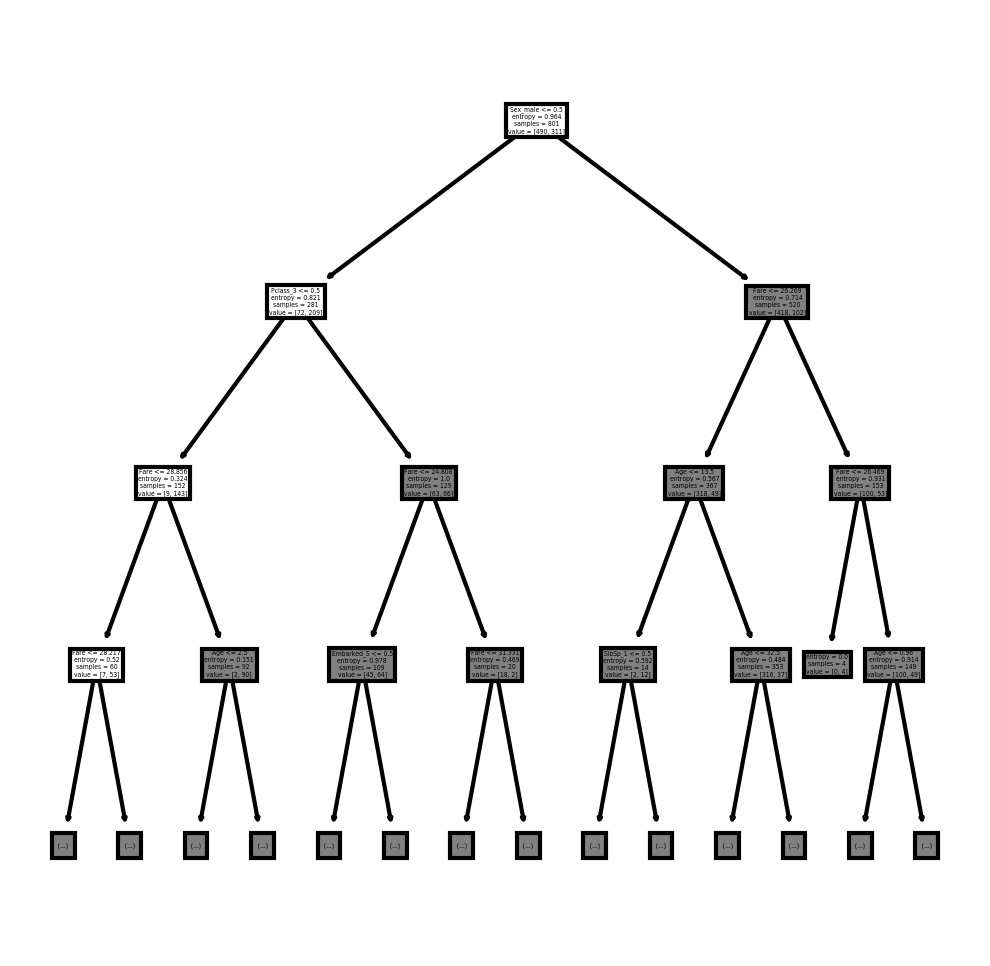

In [41]:
#Отрисовать дерево можно вот так:   
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf_tree, feature_names = X_train.columns, max_depth = 3);

## Сравнение метрик

In [85]:
# метрики при обучении, используя библиотеку sklearn
skl_roc_train = roc_auc_score(y_train, y_pred_train)
skl_roc_test = roc_auc_score(y_test, y_pred_test)

# метрики при обучении, используя собственный алгоритм
my_roc_train = roc_auc_score(y_train, my_pred_train)
my_roc_test = roc_auc_score(y_test, my_pred_test)

In [86]:
print(skl_roc_train)
print(skl_roc_test)

0.9780792702933263
0.8261344997266267


In [87]:
print(my_roc_train)
print(my_roc_test)

0.7625434739812323
0.8108255877528704


In [89]:
assert abs(my_roc_test - 0.6) >= 0.2